# Singular covariance estimates in random regression models

This notebook explores the occurrence of singularity in the estimated covariance matrix of random regression models.  These are mixed-effects models with vector-valued random effects.

This is a [`Julia`](https://julialang.org) notebook using the [`MixedModels`](https://github.com/dmbates/MixedModels.jl) package, which is similar in scope to the [`lme4`](https://github.com/lme4/lme4) package for [`R`](http://r-project.org).

First, fit a model to the `sleepstudy` data from [`lme4`](https://github.com/lme4/lme4).  These data are stored in the `"dat.rda"` file in the `"test"` directory of the [`MixedModels`](https://github.com/dmbates/MixedModels.jl) package and can be read using the [`RData`](https://github.com/JuliaStats/RData.jl) package.  The [`RCall`](https://github.com/JuliaInterop/RCall.jl) package is used to produce some specialized plots with `R`.

Other packages used in this notebook are [`BenchmarkTools`](http://github.com/JuliaCI/BenchmarkTools.jl) for benchmarking execution of functions, [`FreqTables`](http://github.com/nalimilan/FreqTables.jl) for cross-tabulations, [`Gadfly`](http://github.com/GiovineItalia/Gadfly.jl) for graphics, and [`DataFramesMeta`](https://github.com/JuliaStats/DataFramesMeta.jl) for metaprogramming with data frames - in particular the `with` macro.

## Fitting a linear mixed-model to the sleepstudy data

Load the required packages

In [1]:
using BenchmarkTools, DataFrames, DataFramesMeta, FreqTables
using MixedModels, RCall, RData
using Gadfly: plot
using Gadfly.Geom: density, histogram, line, point, smooth
using Gadfly.Guide: xlabel, ylabel

Access the data

In [2]:
dat = convert(Dict{Symbol,Any}, 
    load(Pkg.dir("MixedModels", "test", "dat.rda")))
dat[:sleepstudy]

,Y,U,G
1,249.56,0.0,308
2,258.7047,1.0,308
3,250.8006,2.0,308
4,321.4398,3.0,308
5,356.8519,4.0,308
6,414.6901,5.0,308
7,382.2038,6.0,308
8,290.1486,7.0,308
9,430.5853,8.0,308
10,466.3535,9.0,308


The model specification for the Julia `lmm` function is similar to that for the R function `lmer`.  However, the `lmm` function only creates the model structure.  An explicit call to `fit!` is required to fit the model.  As is customary (though not required) in Julia, a function whose name ends in `!` is a _mutating function_ that modifies one or more of its arguments.

An optional second argument of `true` in the call to `fit!` produces verbose output from the optimization.

In [3]:
sleepm = fit!(lmm(@formula(Y ~ 1+U+(1+U|G)), dat[:sleepstudy]), true)

f_1: 1784.6423 [1.0,0.0,1.0]
f_2: 1790.12564 [1.75,0.0,1.0]
f_3: 1798.99962 [1.0,1.0,1.0]
f_4: 1803.8532 [1.0,0.0,1.75]
f_5: 1800.61398 [0.25,0.0,1.0]
f_6: 1798.60463 [1.0,-1.0,1.0]
f_7: 1752.26074 [1.0,0.0,0.25]
f_8: 1797.58769 [1.18326,-0.00866189,0.0]
f_9: 1754.95411 [1.075,0.0,0.325]
f_10: 1753.69568 [0.816632,0.0111673,0.288238]
f_11: 1754.817 [1.0,-0.0707107,0.196967]
f_12: 1753.10673 [0.943683,0.0638354,0.262696]
f_13: 1752.93938 [0.980142,-0.0266568,0.274743]
f_14: 1752.25688 [0.984343,-0.0132347,0.247191]
f_15: 1752.05745 [0.97314,0.00253785,0.23791]
f_16: 1752.02239 [0.954526,0.00386421,0.235892]
f_17: 1752.02273 [0.935929,0.0013318,0.234445]
f_18: 1751.97169 [0.954965,0.00790664,0.229046]
f_19: 1751.9526 [0.953313,0.0166274,0.225768]
f_20: 1751.94852 [0.946929,0.0130761,0.222871]
f_21: 1751.98718 [0.933418,0.00613767,0.218951]
f_22: 1751.98321 [0.951544,0.005789,0.220618]
f_23: 1751.95197 [0.952809,0.0190332,0.224178]
f_24: 1751.94628 [0.946322,0.0153739,0.225088]
f_25: 1751

Linear mixed model fit by maximum likelihood
 Formula: Y ~ 1 + U + ((1 + U) | G)
   logLik   -2 logLik     AIC        BIC    
 -875.96967 1751.93934 1763.93934 1783.09709

Variance components:
              Column    Variance  Std.Dev.   Corr.
 G        (Intercept)  565.51067 23.780468
          U             32.68212  5.716828  0.08
 Residual              654.94145 25.591824
 Number of obs: 180; levels of grouping factors: 18

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   251.405   6.63226 37.9064  <1e-99
U             10.4673   1.50224 6.96781  <1e-11


The variables in the optimization are the elements of a lower triangular matrix, $\Lambda$, which is the relative covariance factor of the random effects.  The corresponding parameter vector is called $\theta$.

In [4]:
Λ = sleepm.Λ[1]

MixedModels.MaskedLowerTri{Float64}([0.929221 0.0; 0.0181684 0.222645],[1,2,4])

In [5]:
Λ.m

2×2 LowerTriangular{Float64,Array{Float64,2}}:
 0.929221    ⋅      
 0.0181684  0.222645

In [6]:
getθ(sleepm)

3-element Array{Float64,1}:
 0.929221 
 0.0181684
 0.222645 

The matrix $\Lambda$ is the left (or lower) Cholesky factor of the covariance matrix of the unconditional distribution of the vector-valued random effects, relative to the variance, $\sigma^2$, of the per-observation noise.  That is
\begin{equation}
\Sigma = \sigma^2\Lambda\Lambda'
\end{equation}

In terms of the estimates,

In [7]:
s² = varest(sleepm)    # estimate of the residual variance

654.9414530367545

In [8]:
s² * Λ.m * Λ.m'   # unconditional covariance matrix of the random effects

2×2 Array{Float64,2}:
 565.511  11.057 
  11.057  32.6821

The estimated correlation of the random effects can, of course, be evaluated from the covariance matrix.  Writing out the expressions for the elements of the covariance matrix in terms of the elements of Λ shows that many terms cancel in the evaluation of the correlation, resulting in the simpler formula.

In [9]:
Λ.m[2, 1] / sqrt(Λ.m[2, 1]^2 + Λ.m[2, 2]^2)

0.08133219698242103

For a $2\times 2$ covariance matrix it is not terribly important to perform this calculation in an efficient and numerically stable way.  However, it is a good idea to pay attention to stability and efficiency in a calculation that can be repeated tens of thousands of times in a simulation or a parametric bootstrap.  The `norm` function evaluates the (geometric) length of a vector in a way that controls round-off better than the naive calculation.  The `view` function provides access to a subarray, such as the second row of $\Lambda$, without generating a copy.  Thus the estimated correlation can be written

In [10]:
Λ.m[2, 1] / norm(view(Λ.m, 2, :))

0.08133219698242103

### Optimization with respect to θ

As described in section 3 of the 2015 _Journal of Statistical Software_ [paper](https://www.jstatsoft.org/index.php/jss/article/view/v067i01/v67i01.pdf) by Bates, Maechler, Bolker and Walker, using the relative covariance factor, $\Lambda$, in the formulation of mixed-effects models in the [`lme4`](https://github.com/lme4/lme4) and [`MixedModels`](https://github.com/dmbates/MixedModels) packages and using the vector $\theta$ as the optimization variable was a conscious choice.  Indeed, a great deal of effort went into creating this form so that the profiled log-likelihood can be easily evaluated and so that the constraints on the parameters, $\theta$, are simple "box" constraints.  In fact, the constraints are simple lower bounds.

In [11]:
lowerbd(sleepm)

3-element Array{Float64,1}:
    0.0
 -Inf  
    0.0

In contrast, trying to optimize the log-likelihood with respect to standard deviations and correlations of the random effects would be quite difficult because the constraints on the correlations when the covariance matrix is larger than $2\times 2$ are quite complicated.  Also, the correlation itself can be unstable.  Consider what happens to the expression for the correlation if both $\Lambda_{2,1}$ and $\Lambda_{2,2}$ are small in magnitude.  Small perturbations in $\Lambda_{2,1}$ that result in sign changes can move the correlation from near $-1$ to near $+1$ or vice-versa.

### Convergence on the boundary

Determining if an estimated covariance matrix is singular is easy when using the $\theta$  parameters because singularity corresponds to points on the boundary of the allowable parameter space.  In other words, if the optimization converges to a vector in which either or both of $\theta_1$ or $\theta_3$ are zero, the covariance matrix is singular.  Otherwise it is non-singular.

The $\theta_1$ parameter is the estimated relative standard deviation of the random intercepts.  If this is zero then the correlation is undefined and reported as `NaN`.  If $\theta_3$ is zero and $\theta_2$ is non-zero then the estimated correlation is $\pm 1$ with the sign determined by the sign of $\theta_2$.  If both $\theta_2$ and $\theta_3$ are zero the correlation is `NaN` because the standard deviation of the random slopes will be zero.

Singular covariance matrices larger than $2\times 2$ do not necessarily result in particular values, like ±1, for the correlations.

Users of `lmer` or `lmm` are sometimes taken aback by convergence on the boundary if this produces correlations of `NaN` or $\pm 1$.  Some feel that this is a sign of model failure. Others consider such estimates as a sign that Bayesian methods with priors that pull singular covariance matrices away from the boundary should be used.

This type of value judgement seems peculiar.  An important property of maximum likelihood estimates is that these estimates are well-defined once the probability model for the data has been specified.  It may be difficult to determine numerical values of the estimates but the definition itself is straightforward.  If there is a direct method of evaluating the log-likelihood at a particular value of the parameters, then, by definition, the mle's are the parameter values that maximize this log-likelihood.  Bates et al. (2015) provide such a method of evaluating the log-likelihood for a linear mixed-effects model.  Indeed they go further and describe how the fixed-effects parameters and one of the variance components can be profiled out of the log-likelihood evaluation, thereby reducing the dimension of the nonlinear, constrained optimization problem to be solved.

If the mle's correspond to a singular covariance matrix, this is a property of the model and the data.  It is not a mistake in some way.  It is just the way things are.  It reflects the fact that often the distribution of the estimator of a covariance matrix is diffuse.  It is difficult to estimate variances and covariances precisely. A search for papers or books on "covariance estimation" will produce many results, often describing ways of regularizing the estimating process because the data themselves do not provide precise estimates.

For the example at hand a parametric bootstrap is one way of evaluating the precision of the estimates.

## The bootstrap function

The `MixedModels` package provides a `bootstrap` method to create a parametric bootstrap sample from a fitted model.

For reproducibility, set the random number seed to some arbitrary value.

In [12]:
srand(1234321);

Arguments to the `bootstrap` function are the number of samples to generate and the model from which to generate them.  By default the converged parameter estimates are those used to generate the samples. Addition, named arguments can be used to override these parameter values, allowing `bootstrap` to be used for simulation.

`bootstrap` returns a "tuple" of arrays: a vector of objective function values (-2 loglikelihood), a vector of estimates of $\sigma^2$, a matrix of estimates of $\beta$, the fixed-effects parameters, and a matrix of estimates of $\theta$.  In the matrices of estimates the columns correspond to simulations.

In [13]:
slpbstrp = bootstrap(10000, sleepm);
names(slpbstrp)

10-element Array{Symbol,1}:
 :obj
 :σ  
 :β₁ 
 :β₂ 
 :θ₁ 
 :θ₂ 
 :θ₃ 
 :σ₁ 
 :σ₂ 
 :ρ₁ 

The first few bootstrap samples of the parameters are

In [14]:
slpbstrp[1:5, :]

,obj,σ,β₁,β₂,θ₁,θ₂,θ₃,σ₁,σ₂,ρ₁
1,1755.5523228722668,26.519472659770997,238.55004519851425,12.30692691785277,0.6985678205928438,0.028858563617659358,0.20344494833912702,18.525650219207733,5.449262109092042,0.14044358181667577
2,1773.975614921466,26.71926657056476,238.94968639774052,10.271877252616797,1.1998863080126103,0.09477059584259076,0.20009605004447942,32.060082118159706,5.915762383406284,0.42804302290306034
3,1766.8257166312571,27.51448607871755,246.11510374378332,8.870586651141453,0.9259180715834381,0.10770609828421712,0.10400516160314259,25.476159890615506,4.119615765565739,0.7193578504589268
4,1693.7764908728811,21.97008606054014,249.89230448666135,10.548379623919757,1.0248107679483829,-0.13405912890640118,0.2008683671370552,22.515180767594202,5.305671206774636,-0.5551212060622855
5,1724.582300451357,23.702729668494264,252.42396595236576,9.301740381443473,1.0349883482647295,0.015828299210636443,0.20323438340034086,24.532049028960277,4.831797207708485,0.07764686330444852


To obtain the proportion of singular estimated covariance matrices determine the number of zeros in the first or third rows of the `theta` matrix.  Because these are numerical estimates from an optimization procedure, not theoretical values, it is best to count the values less than some tolerance, not just those that are exactly zero.

In [15]:
issmall(x) = x < 1.0e-5  # a one-liner function definition
@with slpbstrp freqtable(issmall.(:θ₁), issmall.(:θ₃))

2×2 Named Array{Int64,2}
Dim1 ╲ Dim2 │ false   true
────────────┼─────────────
false       │  9685    308
true        │     7      0

Here the covariance matrix estimate is non-singular in 9,685 of the 10,000 samples, has an zero estimated intercept variance in 7 samples and is otherwise singular (i.e. correlation estimate of $\pm 1$) in 308 samples.

Empirical densities of the θ components are:

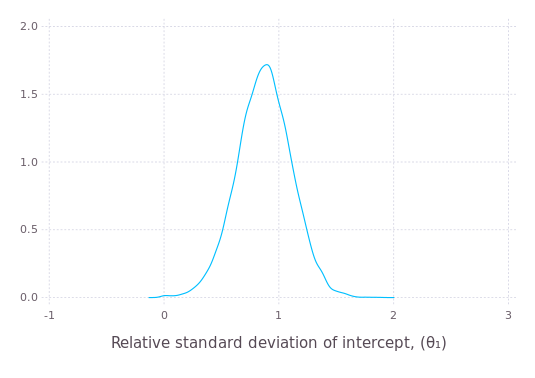

In [16]:
plot(slpbstrp, x = :θ₁, density,
   xlabel("Relative standard deviation of intercept, (θ₁)"))

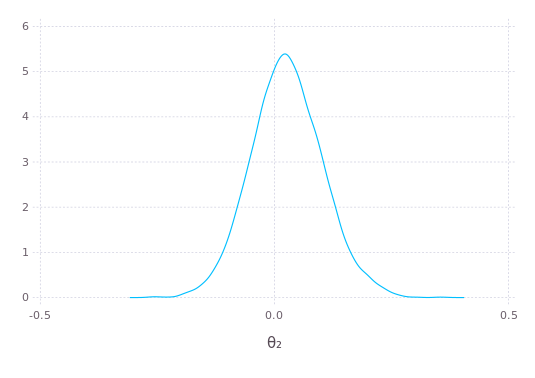

In [17]:
plot(slpbstrp, x = :θ₂, density, xlabel("θ₂"))

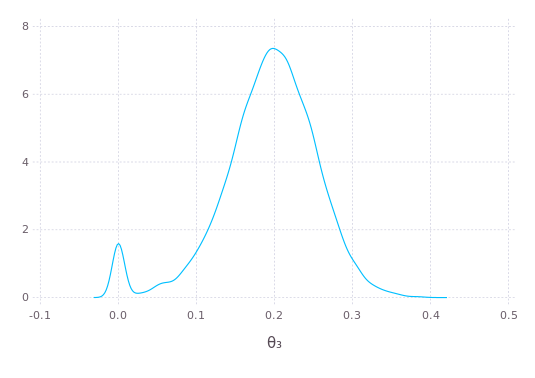

In [18]:
plot(slpbstrp, x = :θ₃, density, xlabel("θ₃"))

These density plots are more-or-less Gaussian in shape except for the spike at zero for $\theta_3$.  This is one of the few cases where a histogram may be more informative than a density plot in that it shows the spike at zero much more clearly.

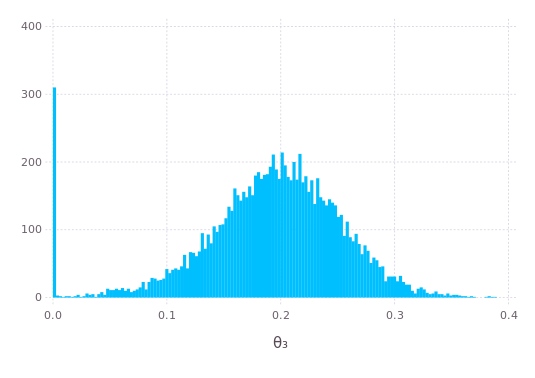

In [19]:
plot(slpbstrp, x = :θ₃, histogram, xlabel("θ₃"))

### Reciprocal condition number

The definitve way to assess singularity of the estimated covariance matrix is by its _condition number_ or, alternatively, its _reciprocal condition number_.   In general the condition number, $\kappa$, of a matrix is the ratio of the largest singular value to the smallest.  For singular matrices it is $\infty$, which is why it is often more convenient to evaluate and plot $\kappa^{-1}$.  Because $\kappa$ is a ratio of singular values it is unaffected by nonzero scale factors.  Thus
\begin{equation}
\kappa^{-1}(s^2\Lambda\Lambda') = \kappa^{-1}(\Lambda\Lambda') =
[\kappa^{-1}(\Lambda)]^2
\end{equation}

In [20]:
function recipcond{T}(θ₁::Vector{T}, θ₂::Vector{T}, θ₃::Vector{T})
    d = Array(T, (2, 2))
    function kappainv(θ₁, θ₂, θ₃) 
        d[1, 1] = θ₁
        d[2, 1] = zero(T) # slight advntg in using upper triangle
        d[1, 2] = θ₂
        d[2, 2] = θ₃
        (mn, mx) = extrema(svdvals!(d))
        mn / mx
    end
    kappainv.(θ₁, θ₂, θ₃)
end
rc = @with slpbstrp recipcond(:θ₁, :θ₂, :θ₃)
extrema(rc)

(0.0,0.8893083252302871)

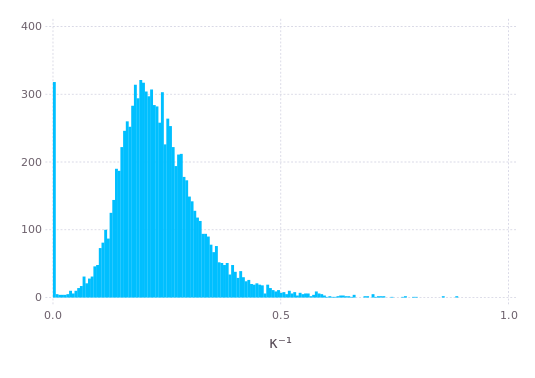

In [21]:
plot(x = rc, histogram(), xlabel("κ⁻¹"))

$\kappa^{-1}$ is small if either or both of $\theta_1$ or $\theta_3$ is small.

In [22]:
sum(issmall, rc)

315

The density of the estimated correlation

In [23]:
sum(isfinite, slpbstrp[:ρ₁])  # recall ρ = NaN in 7 cases b.c. θ₁ = 0

9993

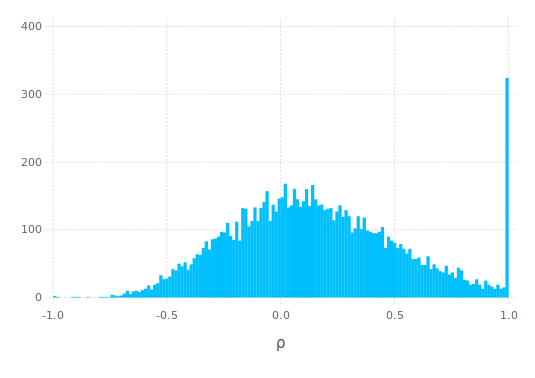

In [24]:
plot(x = filter(isfinite, slpbstrp[:ρ₁]), histogram, xlabel("ρ"))

In [25]:
sum(x -> x == -1, slpbstrp[:ρ₁])  # number of cases of ρ == -1

2

In [26]:
sum(x -> x == +1, slpbstrp[:ρ₁])  # number of cases of rho == +1

306

In this case the bootstrap simulations that resulted in $\rho = -1$ were not close to being indeterminant with respect to sign.  That is, the values of $\theta_2$ were definitely negative.

In [27]:
@where slpbstrp :ρ₁ .== -1

,obj,σ,β₁,β₂,θ₁,θ₂,θ₃,σ₁,σ₂,ρ₁
1,1735.3371439857644,25.981844234861615,248.02809995610917,12.622006332387281,0.14757739236501363,-0.26585437645528825,0.0,3.83433282101484,6.907386998217561,-1.0
2,1677.3571194230246,22.240189976527628,263.87390759697485,11.525523875061202,0.16486529179185602,-0.25449240460225164,0.0,3.666635409986539,5.65995942593741,-1.0


## The Oxboys data

The `Oxboys` data from the `nlme` package for R are height measurements on a sample of boys from Oxford, England over a period of several years.  The `U` variable is standardized time.

In [28]:
dat[:Oxboys]

,G,U,Y,o
1,1,-1.0,140.5,1
2,1,-0.7479,143.4,2
3,1,-0.463,144.8,3
4,1,-0.1643,147.1,4
5,1,-0.0027,147.7,5
6,1,0.2466,150.2,6
7,1,0.5562,151.7,7
8,1,0.7781,153.3,8
9,1,0.9945,155.8,9
10,2,-1.0,136.9,1


The `nlme` package for `R` provides a specialized multi-panel plot of these data using `lattice`.

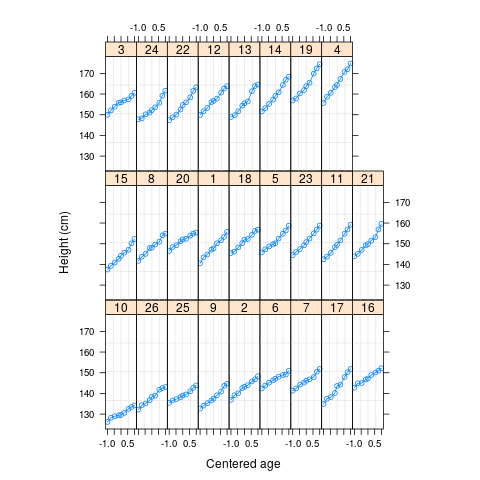

RCall.RObject{RCall.VecSxp}


In [29]:
R"""
library(nlme)
plot(Oxboys)
"""

In [30]:
oxboysm = fit!(lmm(@formula(Y ~ 1+U+(1+U|G)), dat[:Oxboys]))

Linear mixed model fit by maximum likelihood
 Formula: Y ~ 1 + U + ((1 + U) | G)
   logLik   -2 logLik     AIC        BIC    
 -362.98384  725.96769  737.96769  758.69962

Variance components:
              Column     Variance   Std.Dev.   Corr.
 G        (Intercept)  62.79048972 7.9240450
          U             2.71171522 1.6467286  0.64
 Residual               0.43545343 0.6598890
 Number of obs: 234; levels of grouping factors: 26

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   149.372   1.55463 96.0817  <1e-99
U             6.52547   0.32977 19.7879  <1e-86


In [31]:
getθ(oxboysm)

3-element Array{Float64,1}:
 12.0081 
  1.60164
  1.91366

As seen in the plot and by the estimate $\widehat{\theta_1} = 12.0$, the estimated standard deviation of the random intercepts is much greater than the residual standard deviation.  It is unlikely that bootstrap samples will include singular covariance estimates.

In [32]:
srand(4321234)
@time oxbbstrp = bootstrap(10000, oxboysm);

 94.549759 seconds (375.22 M allocations: 10.844 GB, 2.63% gc time)


In this bootstrap sample, there are no singular estimated covariance matrices for the random effects.

In [33]:
@with oxbbstrp freqtable(issmall.(:θ₁), issmall.(:θ₃))

1×1 Named Array{Int64,2}
Dim1 ╲ Dim2 │ false
────────────┼──────
false       │ 10000

The empirical density of the correlation estimates shows that even in this case the correlation is not precisely estimated.

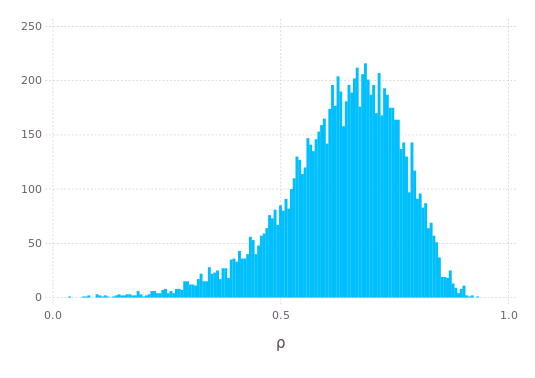

In [34]:
plot(oxbbstrp, x = :ρ₁, histogram, xlabel("ρ"))

In [35]:
extrema(oxbbstrp[:ρ₁])

(0.03362584490815976,0.935265661696695)

The reciprocal condition number

In [36]:
rc = @with oxbbstrp recipcond(:θ₁, :θ₂, :θ₃);
extrema(rc)

(0.061986769151810325,0.36250675712318947)

does not get very close to zero.

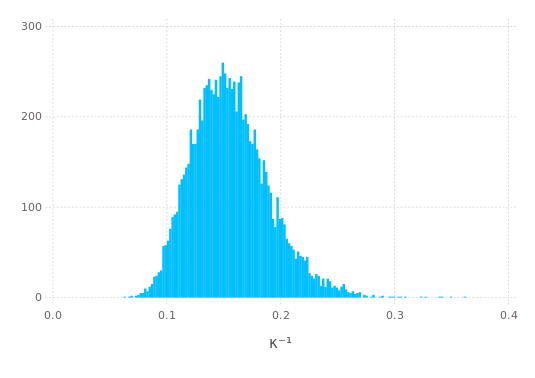

In [37]:
plot(x = rc, histogram, xlabel("κ⁻¹"))

## The Orthodont data

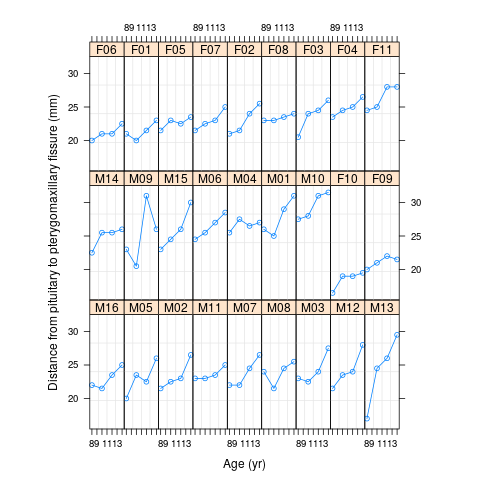

RCall.RObject{RCall.VecSxp}


In [38]:
R"plot(Orthodont)"

The subject labels distinguish between the male and the female subjects.  Consider first the female subjects only.

In [39]:
orthfemale = 
   rcopy(R"""subset(Orthodont, Sex == "Female", -Sex)""");
orthfm = fit!(lmm(@formula(distance ~ 1+age+(1+age|Subject)), orthfemale))

Linear mixed model fit by maximum likelihood
 Formula: distance ~ 1 + age + ((1 + age) | Subject)
   logLik   -2 logLik     AIC        BIC    
  -67.25463  134.50927  146.50927  157.21441

Variance components:
              Column     Variance   Std.Dev.    Corr.
 Subject  (Intercept)  2.971871784 1.72391177
          age          0.021514354 0.14667772 -0.30
 Residual              0.446583516 0.66826904
 Number of obs: 44; levels of grouping factors: 11

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   17.3727  0.725218 23.9552  <1e-99
age          0.479545  0.063133  7.5958  <1e-13


In [40]:
srand(1234123)
orthbstrp = bootstrap(10000, orthfm);
@with orthbstrp freqtable(issmall.(:θ₁), issmall.(:θ₃))

2×2 Named Array{Int64,2}
Dim1 ╲ Dim2 │ false   true
────────────┼─────────────
false       │  6873   3085
true        │    41      1

For this model almost 1/3 of the bootstrap samples converge to singular covariance estimates for the vector-valued random effects.  A histogram of the estimated correlations of the random effects is dominated by the boundary values.

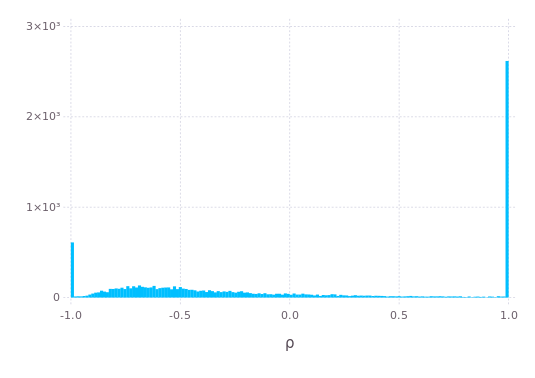

In [41]:
plot(x = filter(isfinite, orthbstrp[:ρ₁]), histogram, xlabel("ρ"))

Even though the estimated correlation in the model is -0.30, more of the boundary values are at +1 than at -1.  This may be an artifact of the optimization routine used.  In some cases there may be multiple optima on the boundary. It is difficult to determine the global optimum in these cases.

A histogram of the reciprocal condition number is also dominated by the boundary values.

In [42]:
rc = @with oxbbstrp recipcond(:θ₁, :θ₂, :θ₃);
extrema(rc)

(0.061986769151810325,0.36250675712318947)

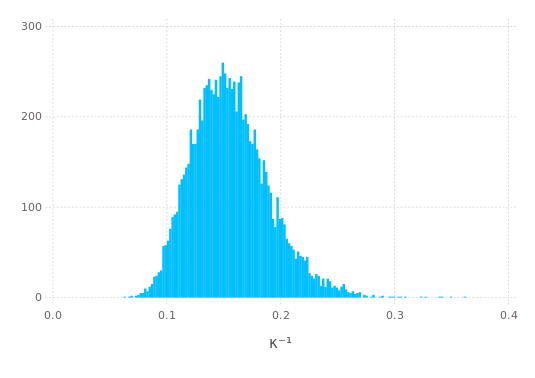

In [43]:
plot(x = rc, histogram, xlabel("κ⁻¹"))

## Early childhood cognitive study

This example from Singer and Willett (2003), *Applied Longitudinal Data Analysis* was the motivation for reformulating the estimation methods to allow for singular covariance matrices. Cognitive scores (`cog`) were recorded at `age` 1, 1.5 and 2 years on 103 infants, of whom 58 were in the treatment group and 45 in the control group.  The treatment began at age 6 months (0.5 years).  The data are available as the `Early` data set in the `mlmRev` package for R.  In the model, time on study (`tos`) is used instead of age because the zero point on the time scale should be when the treatment begins.

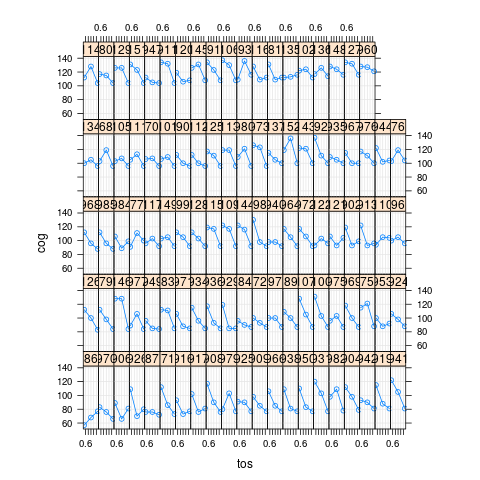

RCall.RObject{RCall.VecSxp}


In [44]:
R"""
suppressMessages(library(mlmRev))
library(lattice)
Early$tos <- Early$age - 0.5
Early$trttos <- Early$tos * (Early$trt == "Y")
xyplot(cog ~ tos | reorder(id, cog, min), Early, 
    type = c("p","l","g"), aspect="xy")
"""

Notice that most of these plots within subjects have a negative slope and that the scores at 1 year of age (`tos = 0.5`) are frequently greater than would be expected on an age-adjusted scale.

In [45]:
R"print(xtabs(cog ~ age + trt, Early) / xtabs(~ age + trt, Early))";

     trt
age           N         Y
  1   108.53333 112.93103
  1.5  95.88889 110.29310
  2    87.40000  97.06897


When the time origin is the beginning of the treatment there is not generally a "main effect" for the treatment but only an interaction of `trt` and `tos`.

In [46]:
early = rcopy(R"subset(Early, select = c(cog, tos, id, trt, trttos))");
earlym = fit!(lmm(@formula(cog ~ 1+tos+trttos+(1+tos|id)), early))

Linear mixed model fit by maximum likelihood
 Formula: cog ~ 1 + tos + trttos + ((1 + tos) | id)
   logLik   -2 logLik     AIC        BIC    
 -1185.6369  2371.2738  2385.2738  2411.4072

Variance components:
              Column    Variance   Std.Dev.    Corr.
 id       (Intercept)  165.476301 12.8637592
          tos           10.744631  3.2779005 -1.00
 Residual               74.946744  8.6571788
 Number of obs: 309; levels of grouping factors: 103

  Fixed-effects parameters:
             Estimate Std.Error  z value P(>|z|)
(Intercept)   120.783    1.8178  66.4448  <1e-99
tos           -22.474    1.4878 -15.1055  <1e-50
trttos        7.65205   1.43609   5.3284   <1e-7


The model converges to a singular covariance matrix for the random effects.

In [47]:
getθ(earlym)

3-element Array{Float64,1}:
  1.48591 
 -0.378634
  0.0     

The conditional (on the observed responses) means of the random effects fall along a line.

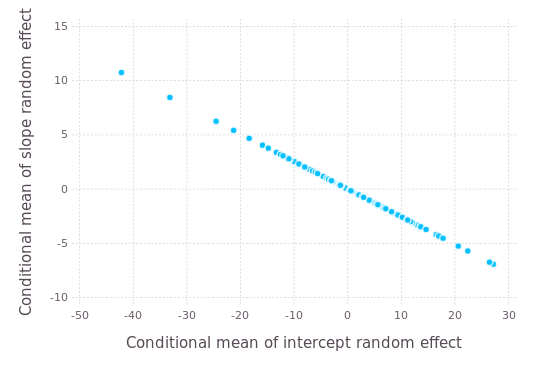

In [48]:
rr = ranef(earlym)[1];
plot(x = view(rr, 1, :), y = view(rr, 2, :), point,
    xlabel("Conditional mean of intercept random effect"),
    ylabel("Conditional mean of slope random effect"))